In [14]:
import psycopg2
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools

import numpy
from numpy import concatenate
from numpy import array

import seaborn as sns

import math
from math import sqrt

# ARIMA AND LSTM STUFF
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import time
import statsmodels.api as sm
import warnings

In [2]:
connection = psycopg2.connect(user = "equipo7",
                            password = "DLgndXy2m4hbWH-qn-Co",
                            host= "ds4a-demo-instance.cssn41frspmj.us-east-1.rds.amazonaws.com",
                            port = "5432",
                            database = "anahuac")
cursor = connection.cursor()
def runquery(query):
    df=pd.read_sql(query,connection)
    return df


def pivot_by_factor(df, index_table, column_table, value_table):
    df = pd.pivot_table(df, index = index_table, columns = column_table, values = value_table)
    df = df.sort_index(axis=1, level=1)
    df.columns = [f'{b}_{a}' for a, b in df.columns]
    df = df.reset_index()
    return df



## Load data from database

It was decided to take **2012 to 2018** as training data, **2019** as test and **january to february 2020** 
as validation for models, For base model **ARIMA**, it was decided to take **2015 to 2018** as trainig.

In [15]:
where_date_clause = " WHERE date >= '2012-01-01' AND date <= '2020-03-01 00:00:00' ORDER BY date"; 

sqlQuery_radiacion = "select * from processed_metrics.radiacion " + where_date_clause
df_radiacion = pd.DataFrame(runquery(sqlQuery_radiacion))

sqlQuery_rama = "select * from processed_metrics.rama " + where_date_clause
df_rama = pd.DataFrame(runquery(sqlQuery_rama))

sqlQuery_redmet = "select * from processed_metrics.redmet " + where_date_clause
df_redmet = pd.DataFrame(runquery(sqlQuery_redmet))

sqlQuery_presion = "select * from processed_metrics.presion " + where_date_clause
df_presion = pd.DataFrame(runquery(sqlQuery_presion))

sqlQuery_weather = "select date,fecha,hora,dewp_c AS dew_point_st,rh_st AS rain_st from processed_metrics.weather_fix  " + where_date_clause
df_weather = pd.DataFrame(runquery(sqlQuery_weather))

In [16]:
#radiation only has data until 2019-12-31 23:00:00. pressure has one more month but we will not consider it
#process radiation
df_radiacion = pivot_by_factor(df_radiacion,["date","fecha","hora"],["factor"],["st"])

#process pa
df_presion.rename(columns={'st': 'PA_st'}, inplace=True)
del df_presion['factor']

#process pollutants
df_rama = pivot_by_factor(df_rama,["date","fecha","hora"],["factor"],["st0","st1","st2"])

#process redmet
df_redmet = pivot_by_factor(df_redmet,["date","fecha","hora"],["factor"],["st0","st1","st2"])

#weather, we are interested in rain and dewpoint, already cleaned when reading from DB


In [17]:
#df_rama, df_redmet,df_weather 71568
#df_presion                    70824
#df_radiacion                  70128
dfs = [df_presion, df_radiacion, df_rama, df_redmet, df_weather]
for df in dfs:
    print("Shape : {} ".format(df.shape))
    print("NaN : {}\n".format(df.isna().sum()))

Shape : (70824, 4) 
NaN : date     0
fecha    0
hora     0
PA_st    8
dtype: int64

Shape : (70128, 5) 
NaN : date       0
fecha      0
hora       0
UVA_st     0
UVB_st    22
dtype: int64

Shape : (71568, 30) 
NaN : date        0
fecha       0
hora        0
CO_st0      0
CO_st1      0
CO_st2      0
NO_st0      0
NO_st1      0
NO_st2      0
NO2_st0     0
NO2_st1     0
NO2_st2     0
NOX_st0     0
NOX_st1     0
NOX_st2     0
O3_st0      0
O3_st1      0
O3_st2      0
PM10_st0    0
PM10_st1    0
PM10_st2    0
PM25_st0    0
PM25_st1    0
PM25_st2    0
PMCO_st0    0
PMCO_st1    0
PMCO_st2    0
SO2_st0     0
SO2_st1     0
SO2_st2     0
dtype: int64

Shape : (71568, 15) 
NaN : date       0
fecha      0
hora       0
RH_st0     0
RH_st1     0
RH_st2     0
TMP_st0    0
TMP_st1    0
TMP_st2    0
WDR_st0    0
WDR_st1    0
WDR_st2    0
WSP_st0    0
WSP_st1    0
WSP_st2    0
dtype: int64

Shape : (71569, 5) 
NaN : date            0
fecha           0
hora            0
dew_point_st    0
rain_st         

In [18]:
#merge all data as one
from functools import reduce
dfs = [df_rama, df_redmet, df_presion, df_radiacion, df_weather]
df_workspace = reduce(lambda left,right: pd.merge(left,right,on=['date','fecha','hora'], how='left'), dfs)


In [19]:
df_workspace.describe()

,hora,CO_st0,CO_st1,CO_st2,NO_st0,NO_st1,NO_st2,NO2_st0,NO2_st1,NO2_st2,...,WDR_st1,WDR_st2,WSP_st0,WSP_st1,WSP_st2,PA_st,UVA_st,UVB_st,dew_point_st,rain_st
count,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,...,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,70816.000000,70128.000000,70106.000000,71568.000000,71568.000000
mean,11.500000,2.182823,2.203050,2.081737,18.016768,20.176152,16.649986,21.182147,24.028906,26.303062,...,178.236301,153.656762,3.419663,3.605691,3.703279,584.714499,1.136723,0.794620,6.731408,47.179739
std,6.922235,1.123193,1.099021,0.961933,24.556083,27.079109,21.200509,8.878447,10.739216,11.030540,...,63.454682,66.697521,1.704319,1.791158,1.790861,1.551186,1.593015,1.260779,4.170254,16.810723
min,0.000000,0.014286,0.014286,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.500000,5.750000,0.275000,0.300000,0.300000,577.000000,0.000000,0.000000,-10.815000,5.759260
25%,5.750000,1.437500,1.444440,1.400000,4.888890,5.571430,4.500000,14.500000,16.333300,18.571400,...,134.200000,102.400000,1.866670,1.933330,2.075000,583.733000,0.000000,0.000000,4.200000,33.916700
50%,11.500000,2.120900,2.214290,2.128570,8.176190,9.375000,8.000000,20.139400,22.200000,24.777800,...,185.750000,145.800000,3.288890,3.628570,3.566670,584.800000,0.062775,0.011250,6.951380,48.634900
75%,17.250000,2.866670,2.925000,2.744440,19.777800,22.400000,19.833300,26.500000,29.625000,32.333300,...,226.857000,207.750000,4.757140,5.060000,5.140000,585.800000,2.112132,1.272362,9.478927,61.355600
max,23.000000,11.600000,8.700000,7.166670,250.000000,270.000000,281.125000,81.666700,111.000000,101.333000,...,304.429000,300.429000,10.466700,9.943330,9.600000,592.000000,6.195000,5.539570,22.000000,81.883600


In [20]:
df_workspace.columns

Index(['date', 'fecha', 'hora', 'CO_st0', 'CO_st1', 'CO_st2', 'NO_st0',
       'NO_st1', 'NO_st2', 'NO2_st0', 'NO2_st1', 'NO2_st2', 'NOX_st0',
       'NOX_st1', 'NOX_st2', 'O3_st0', 'O3_st1', 'O3_st2', 'PM10_st0',
       'PM10_st1', 'PM10_st2', 'PM25_st0', 'PM25_st1', 'PM25_st2', 'PMCO_st0',
       'PMCO_st1', 'PMCO_st2', 'SO2_st0', 'SO2_st1', 'SO2_st2', 'RH_st0',
       'RH_st1', 'RH_st2', 'TMP_st0', 'TMP_st1', 'TMP_st2', 'WDR_st0',
       'WDR_st1', 'WDR_st2', 'WSP_st0', 'WSP_st1', 'WSP_st2', 'PA_st',
       'UVA_st', 'UVB_st', 'dew_point_st', 'rain_st'],
      dtype='object')

In [21]:
df_workspace.fillna(method='ffill', inplace=True)

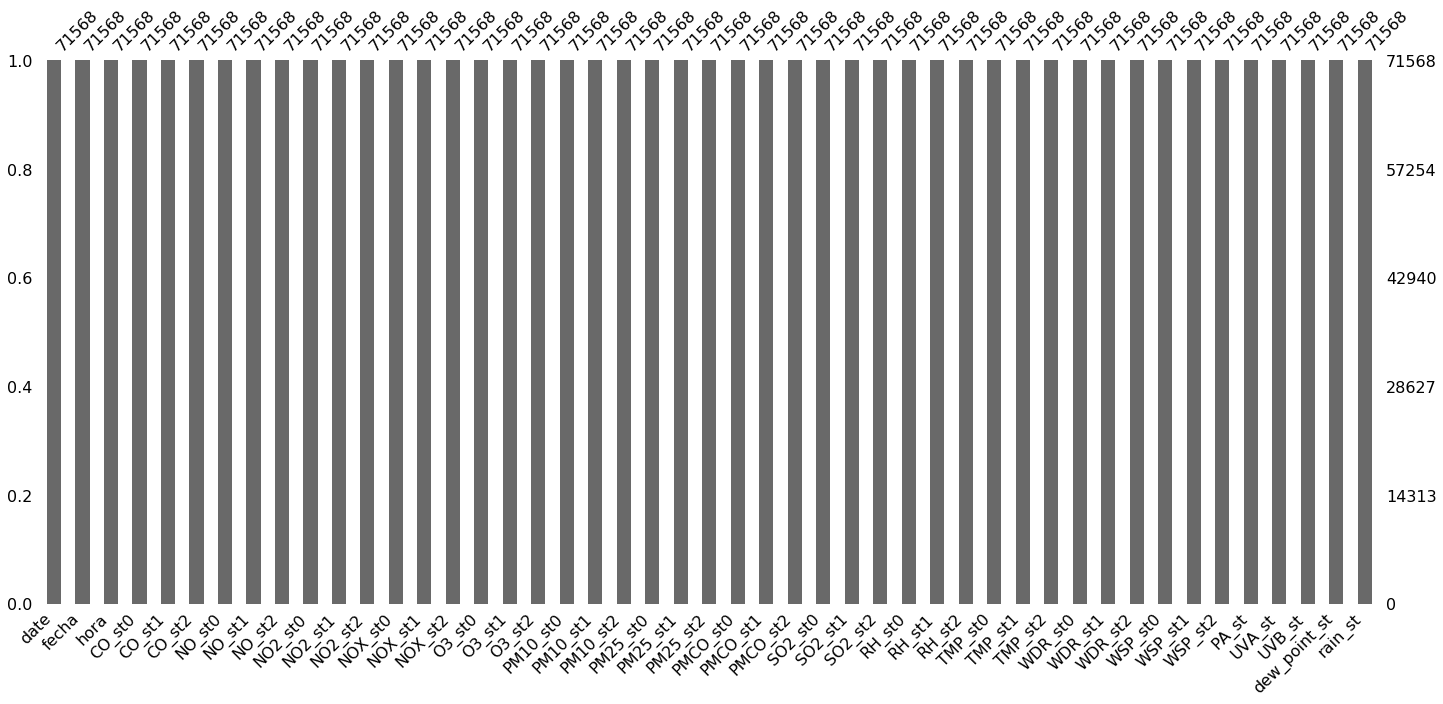

In [22]:
import missingno as msno 
#msno.matrix(df_workspace)  
msno.bar(df_workspace) 

In [23]:
def plot_resample_date(df,start_date,end_date, cols, resample_by):
    df[start_date:end_date][cols].resample(resample_by).mean().plot(figsize=(15, 6))
    plt.show()

In [25]:
# set date as index
df_workspace.set_index('date', inplace=True)

In [28]:
train_u_lstm      = df_workspace['2012-01-01':'2018-12-31']
test_u_lstm       = df_workspace['2019-01-01':'2019-12-31']
validation_u_lstm = df_workspace['2020-01-01':'2020-02-29']

train_hours_u_lstm      = len(train_u_lstm)
test_hours_u_lstm       = len(test_u_lstm)
validation_hours_u_lstm = len(validation_u_lstm)


print(train_u_lstm.shape)
print(test_u_lstm.shape)
print(validation_u_lstm.shape)


(61368, 46)
(8760, 46)
(1440, 46)


# Univariate LSTM

In [64]:
from funcy import print_durations

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #initializing the neural network
    model = Sequential()
    #Long Short-Term Memory layer
    model.add(LSTM(
        neurons, 
        batch_input_shape = (batch_size, X.shape[1], X.shape[2]), 
        stateful=True)
             )
    #Dense is a layer type (fully connected layer)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    #for i in range(nb_epoch):
    #    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #    model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
@print_durations()
def evaluate_lst_model(data, training_hours, test_hours, name_model):
    # transform data to be stationary
    raw_values = data.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train start:training_hours and test training_hours:end  sets
    train = supervised_values[0:training_hours]
    test  = supervised_values[training_hours: training_hours + test_hours]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit the model
    # 1 batch size
    '''
    Online Learning (Batch Size = 1 hour),network weights are updated after each training example 
    This can have the effect of faster learning, but also adds instability to the learning process as the weights
    widely vary with each batch.
    Nevertheless, this will allow us to make one-step forecasts on the problem, that is what we want.
    '''
    # 30 epochs
    #  6 neurons
    lstm_model = fit_lstm(train_scaled, 1, 30, 8)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    #save results
    f = open("results_lstm_u_model_"+name_model+".txt","w+")
    f.write("id\t Predicted\t Expected\n")
    
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        f.write('%d\t %f\t %f\n' % (i+1, yhat, expected))        
    # report performance
    mse = mean_squared_error(raw_values[training_hours: training_hours + test_hours], predictions)
    f.write('MSE for test data: %.3f' % mse)
    print('MSE for test data: %.3f' % mse)
    print('Saving model')
    lstm_model.save("lstm_u_model_"+name_model+".pkl")
   


In [55]:
from joblib import Parallel, delayed
import multiprocessing
cpus = multiprocessing.cpu_count()
print("available processors: ", cpus )

available processors:  8


In [56]:
lstm_univariate_models = ['CO_st0','NO_st0','NO2_st0', 'NOX_st0', 'O3_st0', 'PM10_st0', 'PM25_st0','PMCO_st0',
                         'SO2_st0', 'RH_st0','TMP_st0', 'WDR_st0', 'WSP_st0',   'PA_st', 'UVA_st',   'UVB_st']       
Parallel(n_jobs=multiprocessing.cpu_count())(delayed(evaluate_lst_model)(df_workspace[m], train_hours_u_lstm,test_hours_u_lstm, m) for m in lstm_univariate_models)        


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

[None, None, None, None, None, None, None, None]

In [62]:
resample_by = 'D'
train_u_lstm_d      = df_workspace['2012-01-01':'2018-12-31'].resample(resample_by).mean()
test_u_lstm_d       = df_workspace['2019-01-01':'2019-12-31'].resample(resample_by).mean()
validation_u_lstm_d = df_workspace['2020-01-01':'2020-02-29'].resample(resample_by).mean()
df_workspace_d      = df_workspace.resample(resample_by).mean()   
train_hours_u_lstm_d      = len(train_u_lstm_d)
test_hours_u_lstm_d       = len(test_u_lstm_d)
validation_hours_u_lstm_d = len(validation_u_lstm_d)

In [61]:
print(train_u_lstm_d.shape)
print(test_u_lstm_d.shape)
print(validation_u_lstm_d.shape)
print(df_workspace_d.shape)

(2557, 45)
(365, 45)
(60, 45)
(2982, 45)


In [65]:
lstm_univariate_models = ['CO_st0','NO_st0','NO2_st0', 'NOX_st0', 'O3_st0', 'PM10_st0', 'PM25_st0','PMCO_st0',
                         'SO2_st0', 'RH_st0','TMP_st0', 'WDR_st0', 'WSP_st0',   'PA_st', 'UVA_st',   'UVB_st']       
Parallel(n_jobs=multiprocessing.cpu_count())(delayed(evaluate_lst_model)(df_workspace_d[m], train_hours_u_lstm_d,test_hours_u_lstm_d, m) for m in lstm_univariate_models)        


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]